<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/ConvergenceTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import sympy as sp


clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [0]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

# Working on the mesh

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


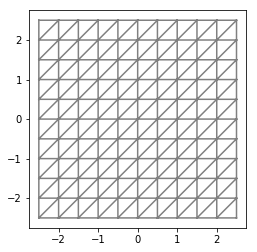

In [57]:
geo_choice = 3
if geo_choice == 1:
    mesh_file = "fru_M_100383_1D.xml"
else:    
    mesh_file = "fru_M_100383_3D.xml"
mesh_file_exists = os.path.isfile(mesh_file)
if (mesh_file_exists==False):
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/$mesh_file''.zip  
    !unzip -q $mesh_file''.zip

# mymesh = Mesh(mesh_file);
#n = 40;
#geometry = Cylinder(Point(0, 0, -2.5), Point(0, 0, 2.5), 1, 1)
#mymesh = generate_mesh(geometry, n)

n=10;
mymesh = RectangleMesh(Point(-2.5, -2.5), Point(2.5, 2.5), n, n)
plot(mymesh)

# Solve the Bloch-Torrey equation

In [60]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [1000]

for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                              # bvalue
    mri_para.delta, mri_para.Delta = 1000, 10000        # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 


    mri_para.Apply()
    mri_simu.k = 10;                                    # time-step size
    mri_simu.nskip = 100;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = None
    mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
    mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
    ################################################################################
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D0 = 2e-3
    mydomain.D = mydomain.D0;
    #################################################################################

    linsolver = PETScLUSolver("mumps")
    # linsolver = KrylovSolver("bicgstab")

    #ic = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e-1, domain=mydomain.mymesh, degree=1);
    #ic = interpolate(ic, mydomain.V);
    #ic = None
    
    #mri_simu.solve(mydomain, mri_para, linsolver, ic)

    mri_simu.Dirac_Delta, mri_simu.u_0 = mri_simu.InitialCondition(mydomain, None)

    stepcounter = 0;

    M = MassMatrix(mydomain);

    mri_simu.t = 0;
    ft_prev  =  mri_para.time_profile(mri_simu.t);
    ift_prev = mri_para.itime_profile(mri_simu.t);

    start_time = time.time()

    while mri_simu.t < mri_para.T: # Time-stepping loop
        if stepcounter % mri_simu.nskip == 0:
            print('t: %6.2f '%mri_simu.t, 'T: %6.2f'%mri_para.T, 'dt: %.1f'%mri_simu.k,'qvalue: %e'%mri_para.qvalue,'Completed %3.2f%%'%(float(mri_simu.t)/float(mri_para.T+mri_simu.k)*100.0));

        ft = mri_para.time_profile(mri_simu.t);
        ift = mri_para.itime_profile(mri_simu.t);

        L = ThetaMethodL(ft_prev, ift_prev, mri_para, mri_simu, mydomain);
        A = 1/mri_simu.k*M + assemble(ThetaMethodF(ft, ift, mri_para, mri_simu, mydomain))

        b = assemble(L);

        linsolver.solve(A, mri_simu.u_0.vector(),b);

        ft_prev  = ft;
        ift_prev = ift;

        mri_simu.t += mri_simu.k;
        stepcounter += 1;

    mri_simu.elapsed_time = time.time() - start_time
    print("Successfully Completed! Elapsed time: %f seconds"%mri_simu.elapsed_time)   

    
    ctext = ""
    #if bvalue==1000:
    #    ctext = "3D realistic neuron, kcoeff=3e-3, delta=10600us, Delta=43100us, dt=200us, gdir=200"
    Post_processing(mydomain, mri_para, mri_simu, None, ctext)

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 0.00%
t: 1000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 9.08%
t: 2000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 18.17%
t: 3000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 27.25%
t: 4000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 36.33%
t: 5000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 45.41%
t: 6000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 54.50%
t: 7000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 63.58%
t: 8000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 72.66%
t: 9000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 81.74%
t: 10000.00  T: 11000.00 dt: 10.0 qvalue: 3.216338e-04 Completed 90.83%
Successfully Completed! Elapsed time: 12.988054 seconds
b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.ticker:vmin 0.12602288265211165 vmax 1.5865340943829762
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.12602288265211165 vmax 1.5865340943829762
DEBUG:matplotlib.ticker:ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
DEBUG:matplotlib.ticker:vmin 0.12602288265211165 vmax 1.5865340943829762
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.12602288265211165 vmax 1.5865340943829762
DEBUG:matplotlib.ticker:ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6

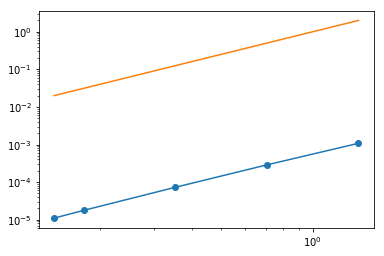

In [71]:
import numpy as np
# For the rectangle
cyl_ref_001=0.84389487095614
# b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2.112e+01, Normalized signal: 8.449737e-01, dt: 10.000, hmin: 1.414e+00, hmax: 1.414e+00, whole_vol: 25.000, vol_of_interest: 25.000, Free signal: 1.353e-01, elasped time 8.389 (s)
# b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2.110e+01, Normalized signal: 8.441826e-01, dt: 10.000, hmin: 7.071e-01, hmax: 7.071e-01, whole_vol: 25.000, vol_of_interest: 25.000, Free signal: 1.353e-01, elasped time 13.294 (s)
# b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2.110e+01, Normalized signal: 8.439677e-01, dt: 10.000, hmin: 3.536e-01, hmax: 3.536e-01, whole_vol: 25.000, vol_of_interest: 25.000, Free signal: 1.353e-01, elasped time 19.423 (s)
# b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2.110e+01, Normalized signal: 8.439126e-01, dt: 10.000, hmin: 1.768e-01, hmax: 1.768e-01, whole_vol: 25.000, vol_of_interest: 25.000, Free signal: 1.353e-01, elasped time 48.678 (s)
# b: 1000.000, g: 1.202, q: 3.216e-04, Signal: 2.110e+01, Normalized signal: 8.439059e-01, dt: 10.000, hmin: 1.414e-01, hmax: 1.414e-01, whole_vol: 25.000, vol_of_interest: 25.000, Free signal: 1.353e-01, elasped time 93.727 (s)

signals=[8.449737e-01, 8.441826e-01, 8.439677e-01, 8.439126e-01, 8.439059e-01];
hmax=[1.414e+00, 7.071e-01, 3.536e-01, 1.768e-01, 1.414e-01];
error=np.abs(np.subtract(signals, cyl_ref_001));
plt.loglog(hmax, error,'-o',hmax, np.power(hmax,2));
